In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt

import torch.nn as nn
import torch

from Function.Stimulation_GPU import *
from Function.ReceptiveField_GPU import *
from Function.plot_SNN import *
from Function.SNN_230320 import SNNModel
from Function.SNNModule import *


In [2]:
print("GPU available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

# Enable GPU support if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

GPU available: True
CUDA version: 10.1


In [260]:
# # on mac
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
# print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
# print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
# !python -c 'import platform;print(platform.platform())'

In [3]:
sensor_h, sensor_w = 19, 16 #(mm)
pixel_h, pixel_w = 64, 48 # (#)
img_FPS = 60

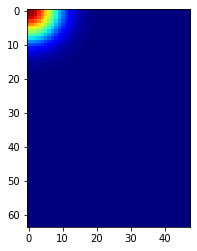

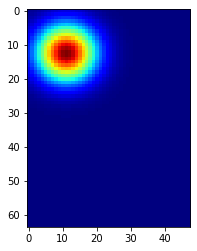

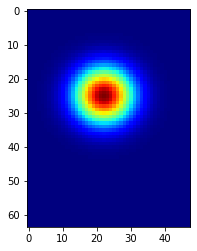

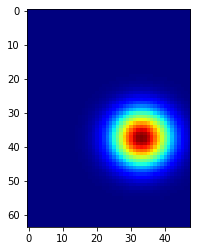

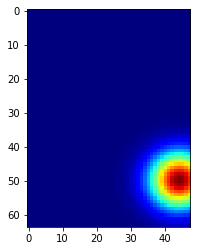

In [4]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_left2right = torch.zeros(
    (pixel_h, pixel_w, num_stim), device=device)

F = 10
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/16
    stim_dot = dot_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w, r=2)
    stimulation_left2right[:, :, i] = stim_dot

    if i % 200 == 0:
        plt.imshow(stimulation_left2right[:, :, i].cpu(), cmap='jet')
        plt.show()


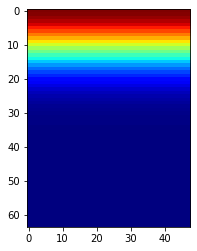

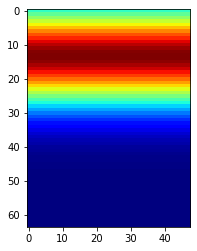

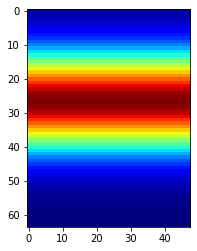

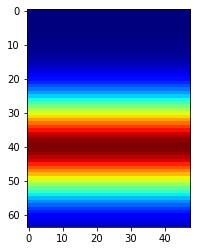

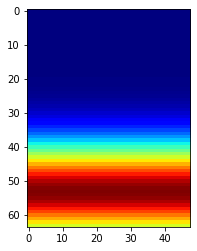

In [5]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_0 = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 20
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w, w=3)
    stimulation_angle_0[:, :, i] = stim_dot
    if i % 200 == 0:
        plt.imshow(stimulation_angle_0[:, :, i].cpu(), cmap='jet')

        plt.show()


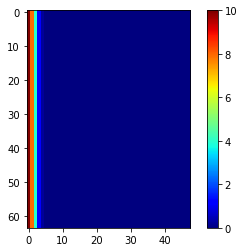

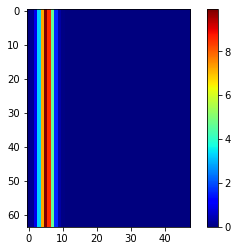

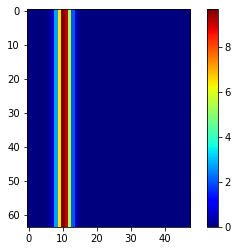

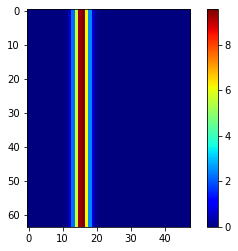

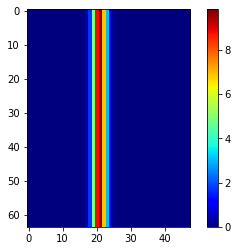

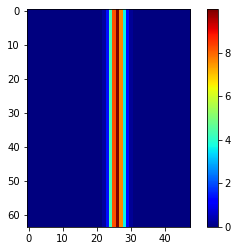

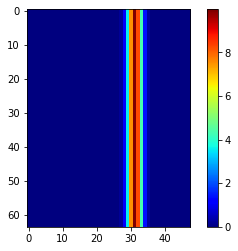

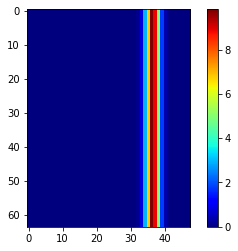

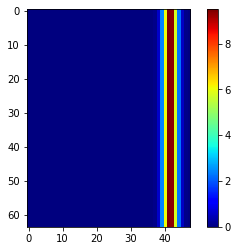

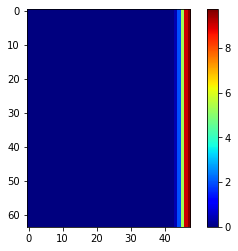

In [6]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_90 = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 10
for i in range(num_stim):
    x0 = i * 0.3/17  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h,
                         pixel_w=pixel_w, theta=np.pi/2, w=0.5)
    stimulation_angle_90[:, :, i] = stim_dot
    if i % 100 == 0:
        plt.imshow(stimulation_angle_90[:, :, i].cpu(), cmap='jet')
        plt.colorbar()
        plt.show()


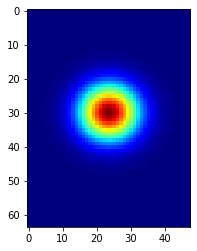

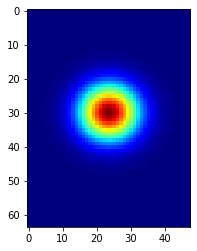

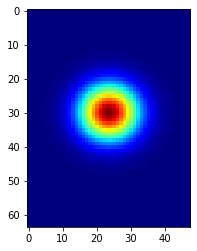

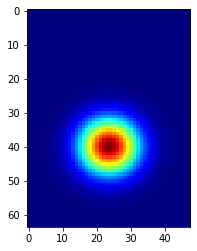

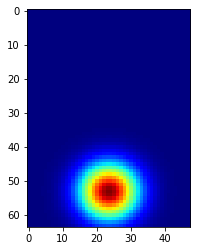

In [7]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_drop = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 20
for i in range(num_stim):
    if i < 500:
        x0 = 8  # Move the stimulus by 0.3mm for each frame
        y0 = 9
    else:
        x0 = 8
        y0 = i*0.3/15
    stim_dot = dot_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w, r=2)
    stimulation_drop[:, :, i] = stim_dot
    if i % 200 == 0:
        plt.imshow(stimulation_drop[:, :, i].cpu(), cmap='jet')
        plt.show()


In [266]:
num_stim = 1000

# Generate the sequence of F values
max_F = 10
F_array = np.concatenate([
    np.zeros((100,)),
    np.linspace(0, max_F, 200),
    np.full((400,), max_F),
    np.linspace(max_F, 0, 200),
    np.zeros((100,))
])

# Preallocate the stimulation_full array
stimulation_full = torch.zeros((pixel_h, pixel_w, num_stim),device = device)

# Create a color map with a range of 0 to max_F
cmap = plt.cm.get_cmap('jet')
cmap.set_under('k')

# Iterate over F_array and generate the stimuli
for i, F_i in enumerate(F_array):
    stim_dot = full_stim(F=F_i, pixel_h=pixel_h, pixel_w=pixel_w)
    stimulation_full[:, :, i] = stim_dot
    
    # if i % 200 == 0:
    #     plt.imshow(stimulation_full[:, :, i].cpu(),
    #                cmap=cmap, vmin=0, vmax=max_F)
        
    #     plt.show()

c:\Users\JaehunKim\anaconda3\envs\pytorch-CUDA10.1\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))


In [267]:
SA_rf,[SA_top_h,SA_top_v] = generate_mechanoreceptor_to_afferent_rf()
RA_rf,[RA_top_h,RA_top_v] = generate_mechanoreceptor_to_afferent_rf(kernel_w=15, kernel_h=15)

print(SA_rf.shape)
receptive_field_init = [torch.tensor([[5, -2.5], [5, -2.5], [5, -2.5], [5, -2.5], [5, -2.5]], device=device),
                        torch.tensor([[5, 5, 5, 5, 5], [-2.5, -2.5, -2.5, -2.5, -2.5]], device=device),
                        10 * torch.ones((7, 7), device=device)]

SA_rf_top, SA_rf_length = generate_afferent_to_top_rf(receptive_field_init, pixel_h=SA_top_v,
                                                                            pixel_w=SA_top_h, step_size=1)

RA_rf_top, RA_rf_length = generate_afferent_to_top_rf(receptive_field_init, pixel_h=RA_top_v,
                                                                              pixel_w=RA_top_h, step_size=1)

print(SA_rf_length)
print(RA_rf_length)

Complete! Generated 70 receptive fields from mechanoreceptor to afferents with kernel size 10x10.
Complete! Generated 54 receptive fields from mechanoreceptor to afferents with kernel size 15x15.
torch.Size([70, 3072])
Complete! Generated 67 receptive fields from afferents to the top with kernel size 7x7.
Complete! Generated 41 receptive fields from afferents to the top with kernel size 7x7.
[36, 27, 4]
[25, 16, 0]


In [268]:
# Create Izhikevich layers
SA_layers = [
    IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_rf), a_decay=1 ,device=device),
    IzhikevichLayer(0.1, 0.2, -65, 8, len(SA_rf_top), a_decay=1,device=device)
    ]

# Create synapses
SA_synapses = [
    Synapse(SA_rf.to(device),device = device),
    Synapse(SA_rf_top.to(device),device = device)
    ]

RA_layers = [
    IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_rf), a_decay=1,device=device),
    IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_rf_top), a_decay=1,device=device)
    ]

RA_synapses =[
    Synapse(RA_rf.to(device),device = device),
    Synapse(RA_rf_top.to(device),device = device)
    ]
    

layer initialized
layer initialized
layer initialized
layer initialized


In [269]:
def run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses, SA_rf_length, RA_rf_length, stim, device='cpu'):
    stim = stim.to(device)
    print(stim.shape[2])

    SA = SNNModel(SA_layers, SA_synapses, device)
    RA = SNNModel(RA_layers, RA_synapses, device)

    SA_stim = stim
    RA_stim = torch.abs(torch.diff(stim, dim=2)) * 20

    SA_spike_times = SA.feedforward(SA_stim)
    RA_spike_times = RA.feedforward(RA_stim)

    plt.plot(SA_stim[1, 1, :])
    plt.plot(RA_stim[1, 1, :])

    plot_spike_times(SA.spike_times[0])
    st_ind = 0
    for i in SA_rf_length:
        plot_spike_times(
            SA.spike_times[1][st_ind:st_ind + i], 'orange', size=(5, 3 * i / 57))
        st_ind += i

    plot_spike_times(RA.spike_times[0])
    st_ind = 0
    for i in RA_rf_length:
        if i != 0:
            st_ind += i
            plot_spike_times(
                RA.spike_times[1][st_ind:st_ind + i], 'g', size=(5, 3 * i / 57))

1000
Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


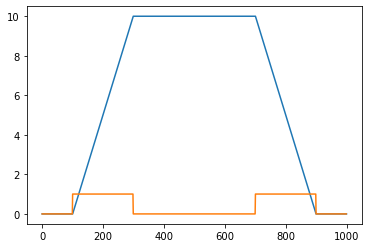

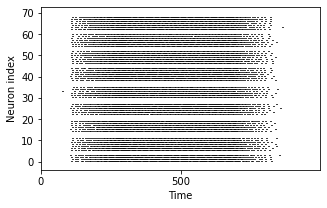

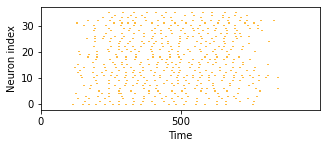

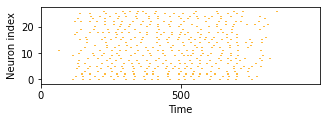

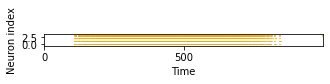

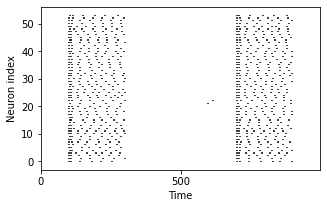

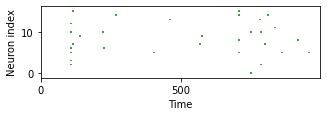

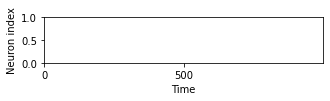

1.385418176651001


In [270]:
stim = stimulation_full.to(device)
start_time = time.time()
run_simulation(SA_layers, RA_layers, SA_synapses, RA_synapses, SA_rf_length, RA_rf_length, stim, device='cpu')
end_time = time.time()

print(end_time - start_time)

1000
Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


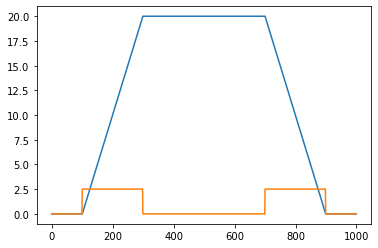

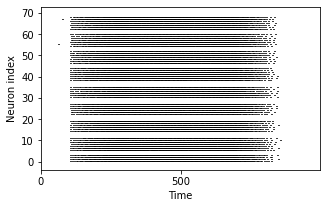

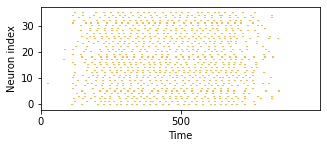

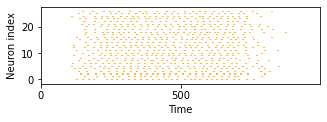

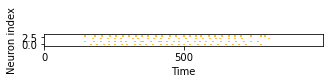

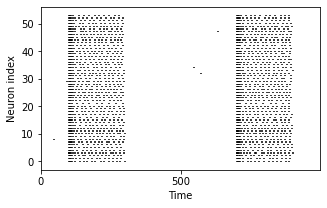

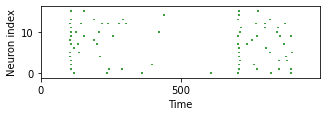

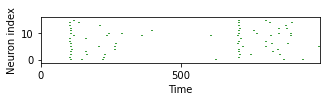

In [271]:
stim = stimulation_full.to(device)
print(stim.shape[2])

SA = SNNModel(SA_layers,SA_synapses,device)
RA = SNNModel(RA_layers,RA_synapses,device)


SA_stim = stim * 2
RA_stim = torch.abs(torch.diff(stim, dim = 2)) * 50

SA_spike_times = SA.feedforward(SA_stim)
RA_spike_times = RA.feedforward(RA_stim)

plt.plot(SA_stim[1,1,:])
plt.plot(RA_stim[1, 1, :])

plot_spike_times(SA.spike_times[0])
st_ind = 0
for i in SA_rf_length:
    plot_spike_times(SA.spike_times[1][st_ind:st_ind + i],'orange',size = (5,3*i/57))
    st_ind = i

plot_spike_times(RA.spike_times[0])
st_ind = 0
for i in RA_rf_length:
    if i != 0:
        st_ind = i
        plot_spike_times(RA.spike_times[1][st_ind:st_ind + i],'g',size = (5,3*i/57))



In [272]:
stim = stimulation_angle_0.to(device)
print(stim.shape[2])

SA = SNNModel(SA_layers,device)
RA = SNNModel(RA_layers,device)

SA_stim = stim 
RA_stim = torch.abs(torch.diff(stim, dim = 2)) * 20

SA_spike_times = SA.feedforward(SA_stim, SA_synapses)
RA_spike_times = RA.feedforward(RA_stim, RA_synapses)

plt.plot(SA_stim[1,1,:])
plt.plot(RA_stim[1, 1, :])

plot_spike_times(SA.spike_times[0])
st_ind = 0
for i in SA_rf_length:
    plot_spike_times(SA.spike_times[1][st_ind:st_ind + i],'orange',size = (5,3*i/57))
    st_ind = i

plot_spike_times(RA.spike_times[0])
st_ind = 0
for i in RA_rf_length:
    if i != 0:
        st_ind = i
        plot_spike_times(
            RA.spike_times[1][st_ind:st_ind + i], 'g', size=(5, 3*i/57))



1000
Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


AttributeError: 'str' object has no attribute 'weights'

1000
Initializing SNN Model with 2 layers with device cpu
Initializing SNN Model with 2 layers with device cpu


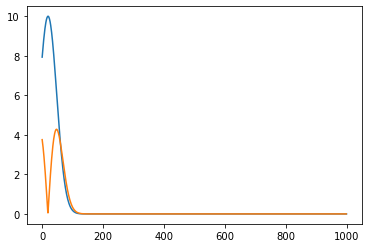

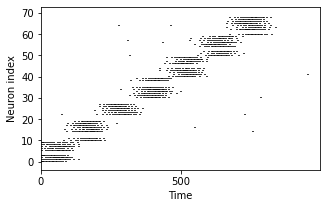

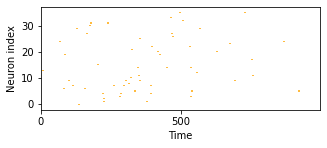

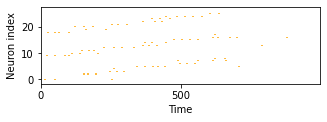

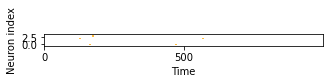

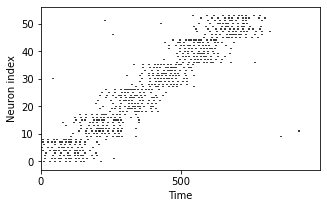

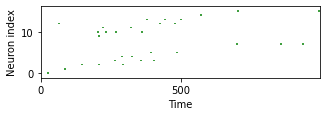

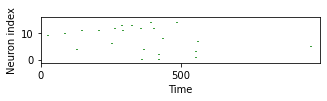

In [ ]:
stim = stimulation_angle_90.to(device)
print(stim.shape[2])

SA = SNNModel(SA_layers,device)
RA = SNNModel(RA_layers,device)


SA_stim = stim 
RA_stim = torch.abs(torch.diff(stim, dim = 2)) * 20

SA_spike_times = SA.feedforward(SA_stim, SA_synapses)
RA_spike_times = RA.feedforward(RA_stim, RA_synapses)


plt.plot(SA_stim[1,1,:])
plt.plot(RA_stim[1, 1, :])


plot_spike_times(SA.spike_times[0])
st_ind = 0
for i in SA_rf_length:
    plot_spike_times(
        SA.spike_times[1][st_ind:st_ind + i], 'orange', size=(5, 3*i/57))
    st_ind = i

plot_spike_times(RA.spike_times[0])
st_ind = 0
for i in RA_rf_length:
    if i != 0:
        st_ind = i
        plot_spike_times(
            RA.spike_times[1][st_ind:st_ind + i], 'g', size=(5, 3*i/57))
